# NLP Project - Text Summarization applied to French news articles

<blockquote>

Instructions : https://docs.google.com/document/d/1ijqISks5L_ioZwJi-VIRx5JLxk01Ao8wLYkN7L-R4RE/edit#

Lien Latex Report : https://fr.overleaf.com/7163467196bvrhtzpxryyg 

</blockquote>

*Project description*

## Proposal : 

<blockquote>

Instructions :  

Provide details on your project . It should be a paragraph describing your project, what datasets you will be using, what modelling techniques and what evaluation you will be doing
</blockquote>

* **Possible Datasets in French :** 
 
    * [OrangeSum](https://github.com/Tixierae/OrangeSum) or ([link HunggingFace](https://huggingface.co/datasets/GEM/OrangeSum) ): dataset that was proposed for text summarization but in **French** (which is less studied in litterature than English) : articles with summaries, already grouped in categories (political, environment, ...) so we will be able to easily compare the perf of our model on different "subjects"

    \+ this dataset was proposed together with "[BARThez](https://huggingface.co/moussaKam/mbarthez?text=Paris+est+la+%3Cmask%3E+de+la+France.)", a seq2seq model proposed specifically for French and which is said to be more efficient than BERT-based models for French, above all for generative tasks ([associated article](https://arxiv.org/pdf/2010.12321.pdf))

  * [CASS](https://github.com/euranova/CASS-dataset) (summaries of "procès en cours de cassation", maybe less interesting and diverse than news articles)

  * [MLSum](https://huggingface.co/datasets/mlsum) & [XL-Sum](https://huggingface.co/datasets/csebuetnlp/xlsum) : datasets proposed by HuggingFace and composed of articles with abstracts on different languages, I guess we can concentrate on French subcorpus. It was originally proposed for multilingual text summarization ([see article for XLSum](https://arxiv.org/pdf/2106.13822v1.pdf) or [article for MLSum](https://arxiv.org/pdf/2004.14900v1.pdf))

  * [WikiLingual](https://paperswithcode.com/dataset/wikilingua) : article and summary pairs of Wikipedia articles in different languages



* **Possible Language models for French :**

  - [CamemBERT](https://camembert-model.fr/)
  - [FlauBERT](https://github.com/getalp/Flaubert)
  - [Deepfrench](https://github.com/tchambon/deepfrench) : pre-trained on Wikipedia corpuses, principally proposed for classification tasks
  - BARThez 

* **Description of the task and approach(es)** :

The idea of text summarization is to produce a summary of a text (or corpus of text if we want to extend it). There is two main possible approches :

**1. Extractive Approach :**

The first (maybe simplest) approach is to form a summary by selecting some sentences of the text (without modifying it at all). To do so, we need to find a way to "score" the sentences of the document to extract only the most revelant ones. 

An example of algorithm that we can try to implement is the TextRank algorithm, which is unsupervised and with few DL. The idea is to compute a similarity matrix between the sentences of our document, which can be done by computing similarities between embeddings of the sentences (with Seq2Vec for instance).

[Example of tuto really well detailed for Extractive Approach](https://www.analyticsvidhya.com/blog/2018/11/introduction-text-summarization-textrank-python//)


**2. Abstractive Approach :**

A more advanced approach is to generate the summary, that is to say to produce a summary with sentences that we have generated and do not exist in the document to summarize. 

For this task, we may use DL, with models such as Transformers with Attention Mechanism (or Encoder-Decoder to start but it's more limited and should lead to worse perf than Transformers).

[Example of tuto really well detailed for Abstractive Approach](https:https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python///)



**⇒ Proposal :**

Our project will focus on the text summarization task applied to the summarization of French written documents. (We will not cover multi-lingual models and summarization of corpus of documents, which are possible extensions of this task).

Formally, our goal will be to implement and compare different approaches to produce a summary from a given text. As a "baseline", we will implement the more "naive" method to adress this task, which is called "Extractive Approach" and is unsupervised : the idea is to choose some embeddings for the sentences of a text, and compute a similarity matrix to form a summary by extracting the most revelant sentences of our text. Then, we will study the more advanced "Abstractive approach", where the idea is to leverage deep learning models (Encoder-Decoder or Attention Mechanism of Transformers), to build supervised generative models that will generate new sentences to create a summary.

Concerning the datasets, we would like to train our models on news articles with their summaries in French, which can be found in datasets such as MLSum, XLSum or OrangeSum. As we are studying French written texts, we will use and compare some language models specific to French, such as FlauBERT, CamemBERT, DeepFrench or BARTHez. Moreover, to evaluate the performance of our generated summaries, we will use the ROUGE metric, which was specifically designed for this task and used in the litterature. We may also do some experiments by challenging our models on different type of texts, such as the ones available in WikiLingual or CASS.

## Imports

In [2]:
!pip install datasets transformers

     |████████████████████████████████| 325 kB 8.3 MB/s 
     |████████████████████████████████| 4.0 MB 15.8 MB/s 
     |████████████████████████████████| 212 kB 15.1 MB/s 
     |████████████████████████████████| 136 kB 36.0 MB/s 
     |████████████████████████████████| 1.1 MB 37.0 MB/s 
     |████████████████████████████████| 77 kB 3.0 MB/s 
     |████████████████████████████████| 127 kB 37.4 MB/s 
     |████████████████████████████████| 895 kB 10.0 MB/s 
     |████████████████████████████████| 6.5 MB 13.0 MB/s 
     |████████████████████████████████| 596 kB 10.7 MB/s 
     |████████████████████████████████| 94 kB 2.3 MB/s 
     |████████████████████████████████| 271 kB 38.9 MB/s 
     |████████████████████████████████| 144 kB 23.1 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling

In [3]:
!pip install rouge

In [4]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from tqdm import tqdm

# To load datasets :
from datasets import load_dataset

## Load Datasets

We have identified 3 datasets containing news article written in French : 

  * [OrangeSum](https://github.com/Tixierae/OrangeSum) or ([link HunggingFace](https://huggingface.co/datasets/GEM/OrangeSum) ) : dataset composed of French articles scrapped from "Orange Actu" website. Articles are provided with their title and short summary, and classified into 5 main categories : France, world, politics, automotive, and society. The society category is itself divided into 8 subcategories: health, environment, people, culture, media, high-tech, unusual ("insolite" in French), and miscellaneous.

  * [MLSum](https://huggingface.co/datasets/mlsum) & [XL-Sum](https://huggingface.co/datasets/csebuetnlp/xlsum) : datasets proposed by HuggingFace and composed of articles with their abstracts on different languages. It was originally proposed for multilingual text summarization, but we can choose to focus on the French subcorpus. Note that the considered articles will be mainly translations of originally English articles.

As the OrangeSum articles were originally written in French, we will mainly train our model on this dataset. The two other ones could be used to have a larger training dataset, or to try to apply our OrangeSum-trained model on other types of articles.

In [6]:
dataset_orangesum = load_dataset("GEM/OrangeSum", "abstract")

# dataset_xlsum = load_dataset("csebuetnlp/xlsum", "french")
# dataset_mlsum = load_dataset("mlsum", "fr")

Generating train split:   0%|          | 0/21401 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1500 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1500 [00:00<?, ? examples/s]

Dataset orange_sum downloaded and prepared to /root/.cache/huggingface/datasets/GEM___orange_sum/abstract/1.1.0/0886904dd6ac7849d4c9fcec77bf8d78622dd651739826ccc8436159b777f910. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
dataset_orangesum

DatasetDict({
    train: Dataset({
        features: ['gem_id', 'input', 'target', 'references'],
        num_rows: 21401
    })
    test: Dataset({
        features: ['gem_id', 'input', 'target', 'references'],
        num_rows: 1500
    })
    validation: Dataset({
        features: ['gem_id', 'input', 'target', 'references'],
        num_rows: 1500
    })
})

In [ ]:
dataset_orangesum['train'][1]

{'gem_id': 'OrangeSum_abstract-train-1',
 'input': 'C\'est désormais officiel : Alain Juppé n\'est plus membre des Républicains. L\'ex-Premier ministre de Jacques Chirac, cofondateur de l\'UMP en 2002, ne paie plus sa cotisation auprès du parti de droite. Mercredi 9 janvier, le maire de Bordeaux a dénoncé un glissement qui s\'opère, selon lui, de la droite vers l\'extême droite. "Je me reconnais de moins en moins dans cette famille politique, à laquelle je suis pourtant très attaché (...). C\'est avec tristesse que je l\'ai quittée, mais il y a une dérive vers des thèses qui sont celles très proches de l\'extrême droite, et une ambiguïté sur l\'Europe", a-t-il déclaré face aux journalistes, réunis pour assister à ses voeux. "On assiste à cette espèce de transfusion régulière, et sur les thèmes de fond, il y a des moments où je me demande qui j\'entends à la radio ? Un membre de LR ou du RN ?", a insisté le maire de Bordeaux. Le même jour, l\'ex-député Thierry Mariani annonçait son dépa

In [ ]:
# dataset_xlsum

DatasetDict({
    train: Dataset({
        features: ['id', 'url', 'title', 'summary', 'text'],
        num_rows: 8697
    })
    test: Dataset({
        features: ['id', 'url', 'title', 'summary', 'text'],
        num_rows: 1086
    })
    validation: Dataset({
        features: ['id', 'url', 'title', 'summary', 'text'],
        num_rows: 1086
    })
})

In [ ]:
# dataset_xlsum['train'][1]

{'id': 'monde-55779833',
 'summary': "Le Japon est confronté à une vague de crimes perpétrés par des personnes âgées. La proportion de crimes commis par des personnes de plus de 65 ans n'a cessé d'augmenter au cours des 20 dernières années. Ed Butler, de la BBC, a enquêté sur les raisons de cette situation.",
 'text': 'De plus en plus de Japonais âgés de plus de 65 ans commettent des crimes pour ensuite se retrouver en prison. Nous sommes à Hiroshima, dans une maison de transition pour les délinquants qui sont sur le point de sortir de prison et donc de se réinsérer dans la communauté. Là, Toshio Takata, 69 ans, explique qu\'il a enfreint la loi parce qu\'il était pauvre. Il voulait un endroit où vivre gratuitement, même s\'il était derrière les barreaux. A ne pas manquer sur BBC Afrique : "J\'ai atteint l\'âge de la retraite et je n\'ai plus d\'argent. J\'ai donc pensé que je pourrais peut-être vivre en prison gratuitement", dit Takata. J\'ai pris un vélo, je l\'ai emmené au poste de 

In [ ]:
# dataset_mlsum

DatasetDict({
    train: Dataset({
        features: ['text', 'summary', 'topic', 'url', 'title', 'date'],
        num_rows: 392902
    })
    validation: Dataset({
        features: ['text', 'summary', 'topic', 'url', 'title', 'date'],
        num_rows: 16059
    })
    test: Dataset({
        features: ['text', 'summary', 'topic', 'url', 'title', 'date'],
        num_rows: 15828
    })
})

In [ ]:
# dataset_mlsum['train'][1]

{'date': '01/01/2010',
 'summary': "Cette demande intervient une semaine après l'attaque terroriste manquée à bord d'un vol à destination des Etats-Unis par un jeune Nigérian qui avait séjourné au Yémen.",
 'text': 'Une semaine après l\'attaque terroriste manquée à bord d\'un vol à destination des Etats-Unis par un jeune Nigérian qui avait séjourné au Yémen, Gordon Brown a appelé, vendredi, à une réunion internationale sur le Yémen et la lutte contre le terrorisme le 28 janvier à Londres. Cette réunion doit se tenir en parallèle avec la conférence internationale sur l\'Afghanistan déjà prévue à Londres à la même date. Selon Downing Street, ce projet a déjà reçu "un fort soutien de la Maison Blanche et de l\'Union européenne", et la Grande-Bretagne s\'attachera dans les prochains jours à obtenir l\'appui de l\'Arabie saoudite et des pays du Golfe. La tentative du jeune Nigérian Omar Farouk Abdulmutallab de faire exploser, le jour de Noël, un avion de ligne américain en provenance d\'Ams

## Pre-processing & Tokenization

The first step is to create our DataLoaders, by tokenizing and cleaning our dataset. Here, we are dealing with articles and their summary, so we have the choice between using the sentence-level or the word-level.

### BARTHez pre-trained tokenizer :

In [ ]:
from transformers import AutoTokenizer

tokenizer_barthez = AutoTokenizer.from_pretrained("moussaKam/barthez")

Downloading:   0%|          | 0.00/1.26k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.51M [00:00<?, ?B/s]

In [ ]:
abstract = dataset_orangesum['train'][2]['target']
abstract

'En 2020, les tribunaux d\'instance fusionnent avec ceux de grande instance pour former un unique "tribunal judiciaire". C\'est la principale mesure de la réforme de la Justice, portée par la garde des sceaux Nicole Belloubet.\n'

In [ ]:
tokens = tokenizer_barthez.tokenize(abstract.strip())
print(tokens)

['▁En', '▁2020,', '▁les', '▁tribunaux', '▁d', "'", 'instance', '▁fusionn', 'ent', '▁avec', '▁ceux', '▁de', '▁grande', '▁instance', '▁pour', '▁former', '▁un', '▁unique', '▁"', 't', 'rib', 'unal', '▁judiciaire', '".', '▁C', "'", 'est', '▁la', '▁principale', '▁mesure', '▁de', '▁la', '▁réforme', '▁de', '▁la', '▁Justice', ',', '▁portée', '▁par', '▁la', '▁garde', '▁des', '▁sceaux', '▁Nicole', '▁Bell', 'oub', 'et', '.']


### Naive method : sentence and word tokenization


> inspired from : https://www.nltk.org/api/nltk.tokenize.html and https://medium.com/data-science-in-your-pocket/text-summarization-using-textrank-in-nlp-4bce52c5b390

In [ ]:
import re
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

In [ ]:
stop_words = stopwords.words('french')

In [ ]:
def tokenize_clean_text (text) : 
    """
    Tokenize and clean a given text
    Input : 
      text : string containing the text to clean and tokenize
    Output : 
      list of token's list 
    """

    # Sentence tokenizer : 
    sentences = sent_tokenize(text, language='french')

    output = []
    for sent in sentences : 
        # Clean of the sentence : removes ponctuation, and lower the sentence
        clean_sent = re.sub(r'[^\w\s]','', sent.lower())

        # Tokenization of the sentence : 
        tok_clean_sent = word_tokenize(clean_sent, language='french')

        # Removing of the stopwords :
        tok_clean_sent = [w for w in tok_clean_sent if w not in stop_words]

        # Append to the output :
        output.append(tok_clean_sent)

    return output

In [ ]:
abstract

'En 2020, les tribunaux d\'instance fusionnent avec ceux de grande instance pour former un unique "tribunal judiciaire". C\'est la principale mesure de la réforme de la Justice, portée par la garde des sceaux Nicole Belloubet.\n'

In [ ]:
tokenize_clean_text(abstract)

[['2020',
  'tribunaux',
  'dinstance',
  'fusionnent',
  'ceux',
  'grande',
  'instance',
  'former',
  'unique',
  'tribunal',
  'judiciaire'],
 ['cest',
  'principale',
  'mesure',
  'réforme',
  'justice',
  'portée',
  'garde',
  'sceaux',
  'nicole',
  'belloubet']]

## Descriptive Statistics

> Instructions : You must describe statistically your dataset 
(distribution of words, bi-grams, POS, sentence/document length, most frequent words….) 


In this section, we will try to provide revelant descriptive statistics, mainly of the OrangeSum dataset (our functions can easily be used on other datasets). We will describe the sentence and text lengths, but also their content in terms of vocabulary (word distribution, ...) and topic. 

We will just use a simple sentence and word tokenizer, using `sent_tokenize` and `word_tokenize` from `nltk.tokenize`.

In [7]:
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

In [8]:
df_orangesum_train = dataset_orangesum['train'].to_pandas()
# df_mlsum_train = dataset_mlsum['train'].to_pandas()
# df_xlsum_train = dataset_xlsum['train'].to_pandas()

In [9]:
df_orangesum_train.rename(columns={'input' : 'text', 'target' : 'abstract'}, inplace=True)
df_orangesum_train.head()

,gem_id,text,abstract,references
0,OrangeSum_abstract-train-0,Thierry Mariani sur la liste du Rassemblement ...,L'information n'a pas été confirmée par l'inté...,[L'information n'a pas été confirmée par l'int...
1,OrangeSum_abstract-train-1,C'est désormais officiel : Alain Juppé n'est p...,Le maire de Bordeaux ne fait plus partie des R...,[Le maire de Bordeaux ne fait plus partie des ...
2,OrangeSum_abstract-train-2,La mesure est décriée par les avocats et les m...,"En 2020, les tribunaux d'instance fusionnent a...","[En 2020, les tribunaux d'instance fusionnent ..."
3,OrangeSum_abstract-train-3,Dans une interview accordée au Figaro mercredi...,"Les médecins jugés ""gros prescripteurs d'arrêt...","[Les médecins jugés ""gros prescripteurs d'arrê..."
4,OrangeSum_abstract-train-4,Le préjudice est estimé à 2 millions d'euros. ...,Il aura fallu mobiliser 90 gendarmes pour cett...,[Il aura fallu mobiliser 90 gendarmes pour cet...


In [ ]:
print('Number of articles :', len(df_orangesum_train))

Number of articles : 21401


### Sentence/Document lengths :

In [ ]:
import re
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

In [ ]:
def stats_lengths (df, text_column='text') : 
    """
    Function that realizes statistics of length on df[text_column], by plotting 
    the number of sentences and the number of word per article, 
    and the number of word per sentence in the entire set
    """ 
    # create an empty dataframe for our stats to not modify the input
    n = len(df)
    stats = pd.DataFrame({'idx':np.arange(n)})

    # compute number of sentences and words in each text :
    stats['nb_sentences'] = df[text_column].apply(lambda x : len(sent_tokenize(x, language='french')))
    stats['nb_words'] = df[text_column].apply(lambda x : len(word_tokenize(x, language='french')))

    # compute the number of word per sentence and concatenate in an array : 
    stats['nb_words_per_sentence'] = df[text_column].apply(lambda x : [len(word_tokenize(sent, language='french')) for sent in sent_tokenize(x, language='french')])
    nb_words_per_sentence = np.concatenate(tests['nb_words_per_sentence'].to_numpy())

    # Plot : 
    fig, ax = plt.subplots(1,3, figsize=(15,5))
    sns.histplot(data=stats, x="nb_sentences", ax=ax[0], stat='density')
    ax[0].set_title('Nb of sentences per text')

    sns.histplot(data=stats, x="nb_words", ax=ax[1], stat='density')
    ax[1].set_title('Nb of words per text')

    sns.histplot(nb_words_per_sentence, ax=ax[2], stat='density')
    ax[2].set_xlabel('nb_words_per_sentence')
    ax[2].set_title('Nb of words per sentences \n (on all corpus) ')

    fig.suptitle(f'Statistics on column {text_column}')

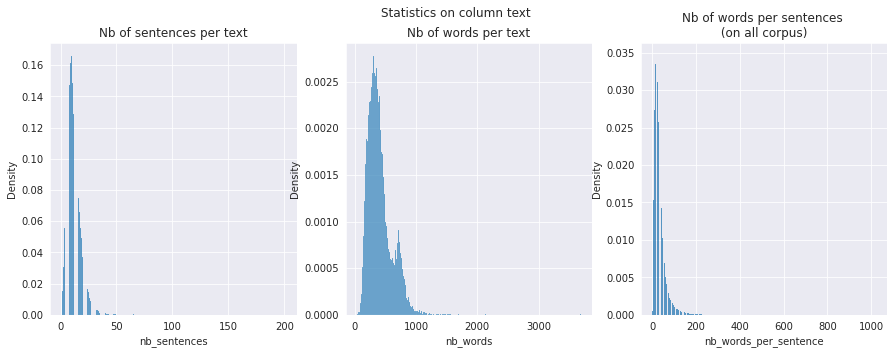

In [ ]:
stats_lengths(df_orangesum_train, text_column='text')

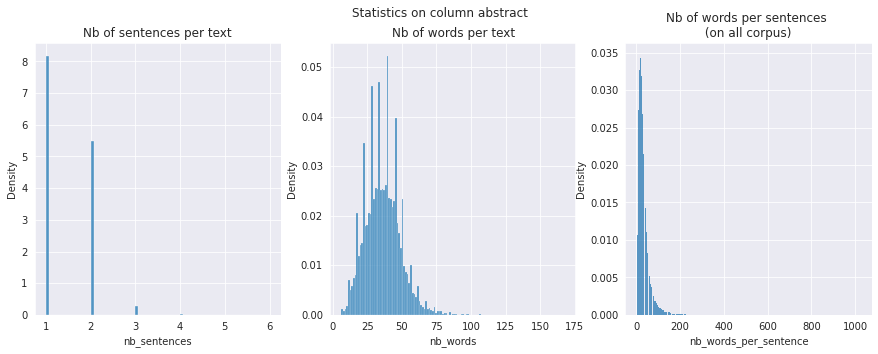

In [ ]:
stats_lengths(df_orangesum_train, text_column='abstract')

### Vocabulary, word distributions, bi-grams, ... :

### Topic description using a pretrained model :

To have an idea of the main topic of the articles of our corpus could be useful, for instance to compare the performance on our summarization model on different type of subjects that may be more or less factual, or to see if the main topic associated to our article is the same than the one associated to our generated summary. 

We used an already existing model found on Hugging Face : [`flaubert-mlsum-topic-classification`](https://huggingface.co/lincoln/flaubert-mlsum-topic-classification?text=La+bourse+de+paris+en+forte+baisse+apr%C3%A8s+que+des+canards+ont+envahit+le+parlement.). This is a classification model, trained on the french MLSUM dataset, which outputs a topic category within : "Culture, Economie, Education, Environnement, Justice, Opinion, Politique, Société, Sport, Technologie". 

Note that we didn't implement the topic modelization by ourselves as it was not the main purpose of our project, but we could have implemented an unsupervised topic modelling such as LDA ([Latent Dirichlet Allocation ](https://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf)), which consists in finding the .

We follow here the instructions given in the [Hugging Face page](https://huggingface.co/lincoln/flaubert-mlsum-topic-classification?text=La+bourse+de+paris+en+forte+baisse+apr%C3%A8s+que+des+canards+ont+envahit+le+parlement.), so we do not have to deal with the pre-processing and tokenization, we re use the one given with the model :

In [10]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TextClassificationPipeline

In [11]:
model_name = 'lincoln/flaubert-mlsum-topic-classification'

loaded_tokenizer = AutoTokenizer.from_pretrained(model_name)
loaded_model = AutoModelForSequenceClassification.from_pretrained(model_name)

topic_classifier = TextClassificationPipeline(model=loaded_model, tokenizer=loaded_tokenizer)

Downloading:   0%|          | 0.00/492 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.25M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/561k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/305 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.99k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/527M [00:00<?, ?B/s]

In [12]:
def topic_description (df, text_column='text') : 
    """
    Use flaubert-mlsum-topic-classification to assign a main topic to each article in df[text_column],
    stored in df[f'main_topic_{text_column}'],
    and plot the proportion of each topic in the corpus.

    !!! : execution might be really long...
    """

    # Creation of a new column in df to store the main topic : 
    new_column = 'main_topic_'+text_column
    df[new_column] = df[text_column].progress_apply(lambda x : topic_classifier(x, truncation=True)[0]['label'])

    # Computation of proportion of each topic in the corpus :
    stats_topics = df[[new_column,text_column]].groupby(new_column).count().reset_index()
    stats_topics[text_column] = stats_topics[text_column] *100 / stats_topics[text_column].sum() 

    # Plot in horizontal barplot :
    fig,ax = plt.subplots(1,1,figsize=(6,4))
    sns.barplot(data=stats_topics, x=text_column, y=new_column, orient='h', ax=ax, palette="Set2")
      # Titles :
    ax.set_xlabel('Proportion in the corpus (%)')
    ax.set_ylabel('Main topic')
    fig.suptitle(f'Main topic of column {text_column} in the corpus')
      # Annotations : 
    for p in ax.patches:
        width = p.get_width()
        plt.text(4+p.get_width(), p.get_y()+0.55*p.get_height(),
                '{:1.1f}%'.format(width), ha='center', va='center')

Run on the $500$ first news article of our train set (computation time being very long...) :

100%|██████████| 500/500 [10:52<00:00,  1.30s/it]


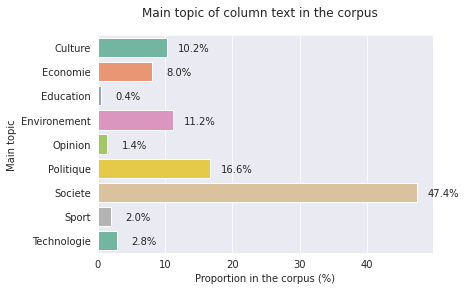

In [13]:
df_orangesum_train_500 = df_orangesum_train.copy()[:500] 
topic_description(df_orangesum_train_500) 

$\hookrightarrow$ It seems that in the first articles of the corpus, the main topics are society and politics, that is to say mainly "abstractive" and "subjective" subjects. It may be harder for the model to understand the opinion within the articles, it can be something to check on our models.

We can also try to see if the main topic attributed to the articles are the same to the ones attributed to the abstracts :

In [14]:
df_orangesum_train_500['main_topic_abstract'] = df_orangesum_train_500['abstract'].progress_apply(lambda x : topic_classifier(x, truncation=True)[0]['label'])
prop_match = (df_orangesum_train_500['main_topic_text']==df_orangesum_train_500['main_topic_abstract']).mean()*100

print(f'Proportion of article-summary pairs with same main topic in the 500 first articles : {prop_match} %')

100%|██████████| 500/500 [01:30<00:00,  5.54it/s]

Proportion of article-summary pairs with same main topic in the 500 first articles : 74.8 %


## Extractive model (baseline) : TextRank algorithm

The first "naive" approach to address the text summarization task is an **extractive** method. It's an unsupervised model, which will try to identify the most revelant sentences in a given document, and will build a summary by extracting them. We will then obtain a summary composed of a "patchwork" of sentences from the article, we won't "generate new sentences".

We have chosen to implement the [TextRank](https://aclanthology.org/W04-3252.pdf) algorithm, which is similar to the PageRank algorithm proposed by Google, but applied here to the scoring of the sentences of a text. Here are the main steps of the algorithm, which will turn our problem into a graph problem :  

1. Identify text units that best define the task at hand, that is to say the sentences in our case, and add them as vertices in our graph.
2. Compute a similarity matrix between the sentences of our text, which will correspond to the weights given to each edges of our graph. Here are some possibilities for the choice of similarity measure between two sentences $S_i = w^i_1 ... w^i_{N_i}$ and $S_j = w^j_1 ... w^j_{N_j}$ :     
  * The similarity measure initially proposed by the TextRank article simply corresponds to the lenght of the overlapping content of both sentences : $$Similarity(S_i,S_j) = \frac{|\{w_k : w_k \in S_i \& w_k \in S_j \}|}{\log(|S_i|) + \log(|S_j|)}$$
  * If we use embedding techniques to transform our sentences into vectors $s_i, s_j \in \mathbb{R}^d$, we can for instance use the cosine similarity, defined by : $$Similarity(s_i,s_j) = \frac{<s_i,s_j>}{\|s_i\|\|s_j\|}$$

3. Iterate the graph-based ranking algorithm until convergence :
  - The score attributed to each sentence $S_i$ according to the weight of its edges defined in the previous step can be summed up into : $$Score(S_i) = (1-\gamma) + \gamma * \sum_{j \neq i} \left( \frac{Similarity(S_i,S_j)}{ \sum_{k \neq j} Similarity(S_k,S_j) } \right) Score(S_j) $$ with $\gamma \in (0,1)$ (authors recommand to choose $\gamma=0.85$). 
  - The previous score being non explicit, we initialize the scores of every sentence randomly, and apply the previous formula until convergence to obtain the final scores. 

4. Sort vertices based on their final score. Build then a summary by keeping the $x$ sentences with highest score, $x$ being chosen by the user.

---
**Pros :**
- The summary is only constructed regarding the given article, no additionnal training on an entire dataset is needed.

**Cons :**
- Sentences extracted from the text, which results in a "patchwork" not always coherent (pronouns, ...)
- May have issues for text composed of very long sentences.
---





In [ ]:
def TextRank (similarity_matrix, gamma=0.85, max_iter=100, tol=1e-16) :
    """
    Parameters :
    - similarity matrix : SM, symmetric, with SM_{ij} = Similarity(S_i, S_j) and SM_{ii} = 0 (shape n x n)
    - gamma : float within (0,1), default 0.85. cf. Score formula.
    - max_iter, tol : int, float. 
      Corresponds to the max number of iterations of the algorithm, and the tolerance used to determine convergence.
    Output : scores attributed to each sentence (shape n)
    """
    n = similarity_matrix.shape[0]
    # normalization of the similarity matrix by column :
    similarity = similarity_matrix / similarity_matrix.sum(axis=0)

    # Initialization of the scores : 
    scores = np.full(shape=n, fill_value=1/n) 
    error,iter = tol + 1, 0

    # Iteration of the algorithm : 
    while (error > tol) and (iter < max_iter) : 
        last_scores = scores.copy()

        # Iteration of the score formula :
        scores = np.dot(similarity , scores) * gamma + (1-gamma)

        # Computation of the error : 
        error = np.sum(abs(scores-last_scores))
        iter += 1

    # Normalization of the final scores :
    scores = scores / scores.sum()

    return scores

#### Toy example : 

In [ ]:
text = dataset_orangesum['train'][2]['input']
abstract = dataset_orangesum['train'][2]['target']

In [ ]:
tok_text = tokenize_clean_text(text)

In [ ]:
# Using a word2vec simple model with 1 dimension per word :

from gensim.models import Word2Vec
w2v = Word2Vec(tok_text, size=1, min_count=1, iter=1000)

text_embeddings=[[w2v[word][0] for word in words] for words in tok_text]
max_len=max([len(tokens) for tokens in tok_text])
text_embeddings = [np.pad(embedding,(0,max_len-len(embedding)),'constant') for embedding in text_embeddings]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [ ]:
np.array(text_embeddings)[:2,:]

array([[1.3254951 , 1.2663769 , 1.5422165 , 1.6837609 , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [1.7838281 , 1.6063561 , 1.3636967 , 1.4833075 , 1.4066556 ,
        1.4024247 , 1.533485  , 1.5384116 , 1.2238238 , 0.97798157,
        1.533485  , 1.337199  , 1.3416679 , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ]], dtype=float32)

In [ ]:
# Construction of the similarity matrix with a cosine similarity :
from scipy import spatial

nb_sentences = len(tok_text)
similarity_matrix = np.zeros((nb_sentences,nb_sentences))
for i,row_embedding in enumerate(text_embeddings):
    for j,column_embedding in enumerate(text_embeddings):
        similarity_matrix[i][j]=1-spatial.distance.cosine(row_embedding,column_embedding)

In [ ]:
# nx function :
import networkx as nx

nx_graph = nx.from_numpy_array(similarity_matrix)
scores = nx.pagerank(nx_graph)

In [ ]:
scores

{0: 0.03540173770563174,
 1: 0.044473273718656024,
 2: 0.04295334728694611,
 3: 0.0439000234620334,
 4: 0.04101381397457181,
 5: 0.039778404758109426,
 6: 0.03264071086483494,
 7: 0.04259254102315404,
 8: 0.042944278416244666,
 9: 0.04497452481984401,
 10: 0.04257808329433321,
 11: 0.04370854251365607,
 12: 0.04111834108550818,
 13: 0.04468138124498301,
 14: 0.04434178040445358,
 15: 0.03576507683099039,
 16: 0.041710610142381324,
 17: 0.032552706414860334,
 18: 0.042975273675417744,
 19: 0.044569803843323416,
 20: 0.044875716689530526,
 21: 0.04245646793767342,
 22: 0.04399933379278063,
 23: 0.04399422610008179}

In [ ]:
# diy function : 
scores_ = TextRank(similarity_matrix)

In [ ]:
scores_

array([0.03540141, 0.04447323, 0.04295323, 0.04389991, 0.04101403,
       0.03977867, 0.03264036, 0.04259273, 0.04294448, 0.04497466,
       0.04257792, 0.04370875, 0.04111816, 0.04468153, 0.04434196,
       0.03576474, 0.04171042, 0.03255235, 0.0429751 , 0.04456986,
       0.04487587, 0.04245671, 0.04399952, 0.0439944 ])

In [ ]:
# Build a summary with x sentences :
x=2
text_sentences = np.array(sent_tokenize(text))
indices_best_x = np.argsort(scores_)[:-(x+1):-1]

summary = text_sentences[indices_best_x]
summary = ''.join(summary)

In [ ]:
summary

'Alors que les particuliers pouvaient se présenter directement au greffe du tribunal d\'instance pour déposer leur requête, la réforme renforce le recours accru aux procédures dématérialisées et étend la représentation obligatoire par un avocat.Elle ne serait "pas étonnée" que le gouvernement ait souhaité "différer des annonces" selon les résultats électoraux de La République en marche dans les communes concernées, comme l\'écrivait Le Canard enchaîné dans une série d\'articles fin octobre.'

In [ ]:
abstract

'En 2020, les tribunaux d\'instance fusionnent avec ceux de grande instance pour former un unique "tribunal judiciaire". C\'est la principale mesure de la réforme de la Justice, portée par la garde des sceaux Nicole Belloubet.\n'

In [ ]:
from rouge import Rouge
Rouge().get_scores(summary, abstract, avg=True)

{'rouge-1': {'f': 0.18749999562717026,
  'p': 0.13846153846153847,
  'r': 0.2903225806451613},
 'rouge-2': {'f': 0.019230764829882663,
  'p': 0.014285714285714285,
  'r': 0.029411764705882353},
 'rouge-l': {'f': 0.18749999562717026,
  'p': 0.13846153846153847,
  'r': 0.2903225806451613}}

## Abstractive models

## Tests & Experiments